## General information

In this kernel I'll try various technics for models interpretability and feature selection. Also I'll compare various models.
I use the features from my dataset: https://www.kaggle.com/artgor/lanl-features
This dataset was created using this kernel: https://www.kaggle.com/artgor/even-more-features/

In [2]:
import os
import gc
import eli5
import shap
import time
import json
import builtins
import datetime
import warnings
import librosa, librosa.display

import numpy as np
import pandas as pd
import altair as alt
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from catboost import CatBoostRegressor
from sklearn import svm, neighbors, linear_model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.signal import hilbert, hann, convolve
from altair.vega import v3
from IPython.display import HTML

from features import gpi_new, gpii_new, gpiii_new

#Configure the environment
%matplotlib inline
pd.options.display.precision = 15
warnings.filterwarnings("ignore")

importing and setting up altair

In [3]:
# Preparing altair. I use code from this great kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey

vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
)))

In [4]:
os.listdir('../input/lanl-features')

['test_features.csv',
 'train_features_denoised.csv',
 'test_features_denoised.csv',
 'submission_1.csv',
 'y.csv',
 'train_features.csv']

* 'train_features.csv' - train features generated on original data
* 'train_features_denoised.csv' - train features generated on denoised data
* 'test_features.csv' - test features generated on original data
* 'test_features_denoised.csv' - test features generated on denoised data
* 'submission_1.csv' - one of my local submissions
* 'y.csv' - train target

## Loading data
Let's load features!

In [5]:
train_features = pd.read_csv('../input/lanl-features/train_features.csv')
test_features = pd.read_csv('../input/lanl-features/test_features.csv')
train_features_denoised = pd.read_csv('../input/lanl-features/train_features_denoised.csv')
test_features_denoised = pd.read_csv('../input/lanl-features/test_features_denoised.csv')
train_features_denoised.columns = [f'{i}_denoised' for i in train_features_denoised.columns]
test_features_denoised.columns = [f'{i}_denoised' for i in test_features_denoised.columns]
y = pd.read_csv('../input/lanl-features/y.csv')

In [6]:
X = pd.concat([train_features, train_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X_test = pd.concat([test_features, test_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X = X[:-1]
y = y[:-1]

We have almost 2000 features here!

In [7]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

## Training function

Training function is in the hidden cell below

In [8]:
def train_model(X, X_test, y, params, folds, model_type='lgb',
                model=None, show_scatter=False, plot_feature_importance=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric='mae',
                      verbose=10000,
                      early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data,
                              num_boost_round=20000,
                              evals=watchlist,
                              early_stopping_rounds=200,
                              verbose_eval=500,
                              params=params)
            
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns),
                                   ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            y_pred = model.predict(X_test).reshape(-1,)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', task_type='GPU', loss_function='MAE', **params)
            model.fit(X_train,
                      y_train,
                      eval_set=(X_valid, y_valid),
                      cat_features=[],
                      use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if model_type == 'gpi_new':
            y_pred_valid = gpi_new(X_valid, activation=params['activation']).values
            y_pred = gpi_new(X_test, activation=params['activation']).values
            
        if model_type == 'gpii_new':
            y_pred_valid = gpii_new(X_valid, activation=params['activation']).values
            y_pred = gpii_new(X_test, activation=params['activation']).values
            
        if model_type == 'gpiii_new':
            y_pred_valid = gpiii_new(X_valid, activation=params['activation']).values
            y_pred = gpiii_new(X_test, activation=params['activation']).values
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    if show_scatter:
        fig, axis = plt.subplots(1, 2, figsize=(12,5))
        ax1, ax2 = axis
        ax1.set_xlabel('actual')
        ax1.set_ylabel('predicted')
        ax2.set_xlabel('train index')
        ax2.set_ylabel('time to failure')
        
        ax1.scatter(y, oof, color='brown')
        ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')

        ax2.plot(y, color='blue', label='y_train')
        ax2.plot(oof, color='orange')

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

## First model

Fold 0 started at Sun May  5 12:08:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[664]	training's l1: 1.23868	valid_1's l1: 2.09886
Fold 1 started at Sun May  5 12:08:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[805]	training's l1: 1.13921	valid_1's l1: 2.00676
Fold 2 started at Sun May  5 12:08:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's l1: 1.33611	valid_1's l1: 2.15575
Fold 3 started at Sun May  5 12:08:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[451]	training's l1: 1.46945	valid_1's l1: 1.94486
Fold 4 started at Sun May  5 12:08:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[579]	training's l1: 1.32006	valid_1's l1: 2.07496
CV mean score: 2.0562, std: 0.0734.


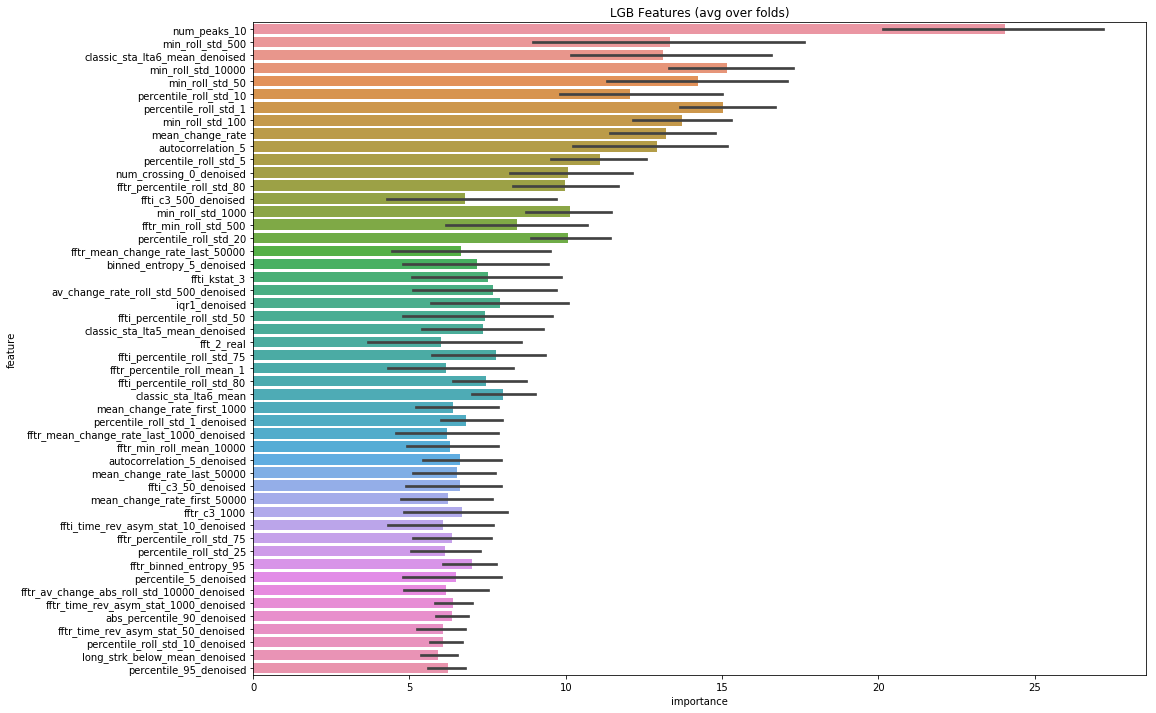

In [9]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 0.1
}
oof_lgb, prediction_lgb, feature_importance = train_model(X,
                                                          X_test,
                                                          y,
                                                          params=params,
                                                          folds=folds,
                                                          model_type='lgb',
                                                          plot_feature_importance=True)

In [10]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission.csv')

In [11]:
sub1 = pd.read_csv('../input/lanl-features/submission_1.csv')
sub1.to_csv('submission_1.csv', index=False)

## NN features
Here I normalize the data and create features using NearestNeighbors. The idea is to find samples which are similar and use it to generate features.

In [12]:
scaler = StandardScaler()
scaler.fit(X)

#alldata = pd.concat([X,X_test])
#scaler = StandardScaler()
#alldata[alldata.columns] = scaler.fit_transform(alldata[alldata.columns].astype(float))

X_train_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [13]:
%%time
n = 10
neigh = NearestNeighbors(n, n_jobs=-1)
neigh.fit(X_train_scaled)

dists, _ = neigh.kneighbors(X_train_scaled, n_neighbors=n)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train_scaled['mean_dist'] = mean_dist
X_train_scaled['max_dist'] = max_dist
X_train_scaled['min_dist'] = min_dist

test_dists, _ = neigh.kneighbors(X_test_scaled, n_neighbors=n)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test_scaled['mean_dist'] = test_mean_dist
X_test_scaled['max_dist'] = test_max_dist
X_test_scaled['min_dist'] = test_min_dist

CPU times: user 5min 12s, sys: 66.6 ms, total: 5min 12s
Wall time: 10.4 s


Fold 0 started at Sun May  5 12:09:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[626]	training's l1: 1.33564	valid_1's l1: 2.09692
Fold 1 started at Sun May  5 12:09:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[983]	training's l1: 1.08657	valid_1's l1: 2.00284
Fold 2 started at Sun May  5 12:09:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[408]	training's l1: 1.5359	valid_1's l1: 2.15788
Fold 3 started at Sun May  5 12:09:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[396]	training's l1: 1.58713	valid_1's l1: 1.93662
Fold 4 started at Sun May  5 12:09:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[294]	training's l1: 1.67626	valid_1's l1: 2.07807
CV mean score: 2.0545, std: 0.0769.


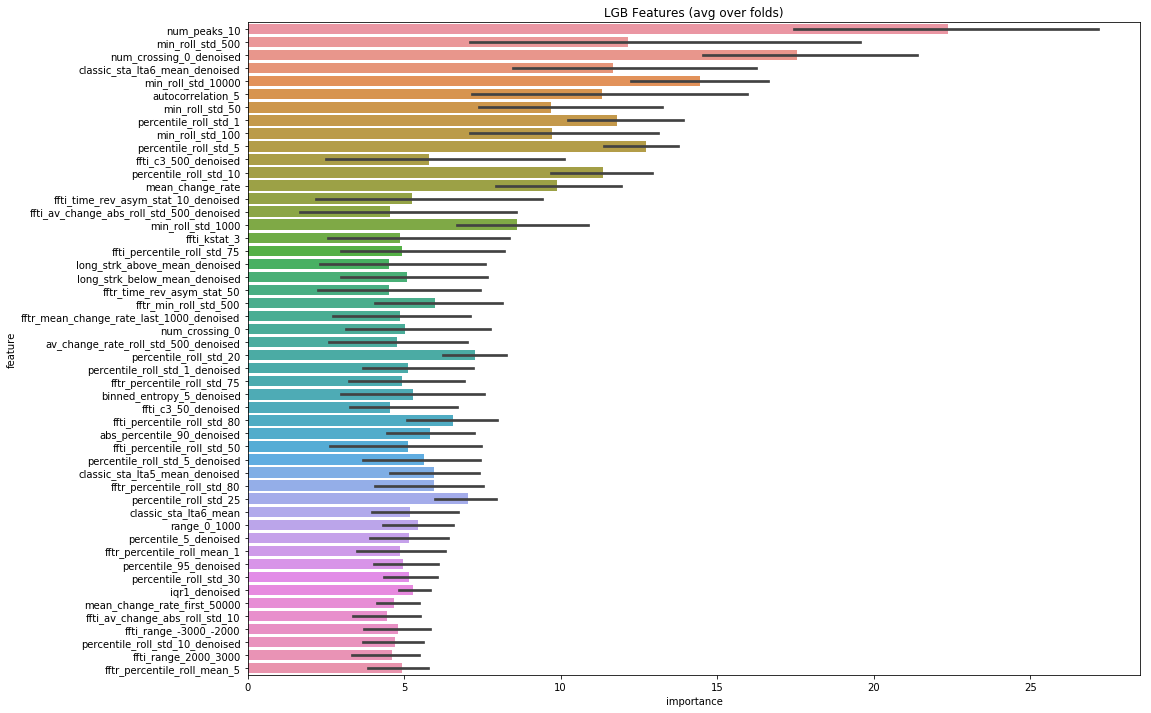

In [14]:
params = {'num_leaves': 32,
          'min_data_in_leaf': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 0.1
         }
oof_lgb, prediction_lgb, feature_importance = train_model(X_train_scaled,
                                                          X_test_scaled,
                                                          y,
                                                          params=params,
                                                          folds=folds,
                                                          model_type='lgb',
                                                          plot_feature_importance=True)

In [15]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission_nn.csv')

## Model interpretation


### ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

**Important notice**: running eli5 on all features takes a lot of time, so I run the cell below in `version 14` and printed the top-50 features. In the following versions I'll use these 50 columns and use eli5 to find top-40 of them so that it takes less time

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train,
          y_train, 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_metric='mae',
          verbose=10000,
          early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=50, feature_names=X.columns.values.tolist())

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[918]	training's l1: 1.12395	valid_1's l1: 1.95277


Weight,Feature
0.0308 ± 0.0023,num_peaks_10
0.0141 ± 0.0017,num_crossing_0_denoised
0.0140 ± 0.0011,percentile_5_denoised
0.0131 ± 0.0013,percentile_roll_std_1
0.0109 ± 0.0005,mean_change_rate
0.0108 ± 0.0012,min_roll_std_50
0.0105 ± 0.0010,min_roll_std_10000
0.0103 ± 0.0010,abs_percentile_90_denoised
0.0102 ± 0.0008,percentile_95_denoised
0.0091 ± 0.0009,fftr_percentile_roll_std_70_denoised


In [17]:
#top_columns = ['iqr1_denoised', 'percentile_5_denoised', 'abs_percentile_90_denoised', 'percentile_95_denoised', 'ave_roll_std_10', 'num_peaks_10', 'percentile_roll_std_20',
#               'ratio_unique_values_denoised', 'fftr_percentile_roll_std_75_denoised', 'num_crossing_0_denoised', 'percentile_95', 'ffti_percentile_roll_std_75_denoised',
#               'min_roll_std_10000', 'percentile_roll_std_1', 'percentile_roll_std_10', 'fftr_percentile_roll_std_70_denoised', 'ave_roll_std_50', 'ffti_percentile_roll_std_70_denoised',
#               'exp_Moving_std_300_mean_denoised', 'ffti_percentile_roll_std_30_denoised', 'mean_change_rate', 'percentile_roll_std_5', 'range_-1000_0', 'mad',
#               'fftr_range_1000_2000_denoised', 'percentile_10_denoised', 'ffti_percentile_roll_std_80', 'percentile_roll_std_25', 'fftr_percentile_10_denoised',
#               'ffti_range_-2000_-1000_denoised', 'autocorrelation_5', 'min_roll_std_100', 'fftr_percentile_roll_std_80', 'min_roll_std_500', 'min_roll_std_50', 'min_roll_std_1000',
#               'ffti_percentile_20_denoised', 'iqr1', 'classic_sta_lta5_mean_denoised', 'classic_sta_lta6_mean_denoised', 'percentile_roll_std_10_denoised',
#               'fftr_percentile_70_denoised', 'ffti_c3_50_denoised', 'ffti_percentile_roll_std_75', 'abs_percentile_90', 'range_0_1000', 'spkt_welch_density_50_denoised',
#               'ffti_percentile_roll_std_40_denoised', 'ffti_range_-4000_-3000', 'mean_change_rate_last_50000']


#X_train, X_valid, y_train, y_valid = train_test_split(X[top_columns], y, test_size=0.2)
#model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1, verbose=-1)
#model.fit(X_train,
#          y_train, 
#          eval_set=[(X_train, y_train), (X_valid, y_valid)],
#          eval_metric='mae',
#          verbose=10000,
#          early_stopping_rounds=200)

#perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)
#eli5.show_weights(perm, top=50, feature_names=top_columns)

Fold 0 started at Sun May  5 12:13:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[573]	training's l1: 1.81443	valid_1's l1: 2.12979
Fold 1 started at Sun May  5 12:13:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[645]	training's l1: 1.80412	valid_1's l1: 2.05482
Fold 2 started at Sun May  5 12:13:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1119]	training's l1: 1.64438	valid_1's l1: 2.15471
Fold 3 started at Sun May  5 12:13:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's l1: 1.96727	valid_1's l1: 1.96149
Fold 4 started at Sun May  5 12:13:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[605]	training's l1: 1.81032	valid_1's l1: 2.11201
CV mean score: 2.0826, std: 0.0689.


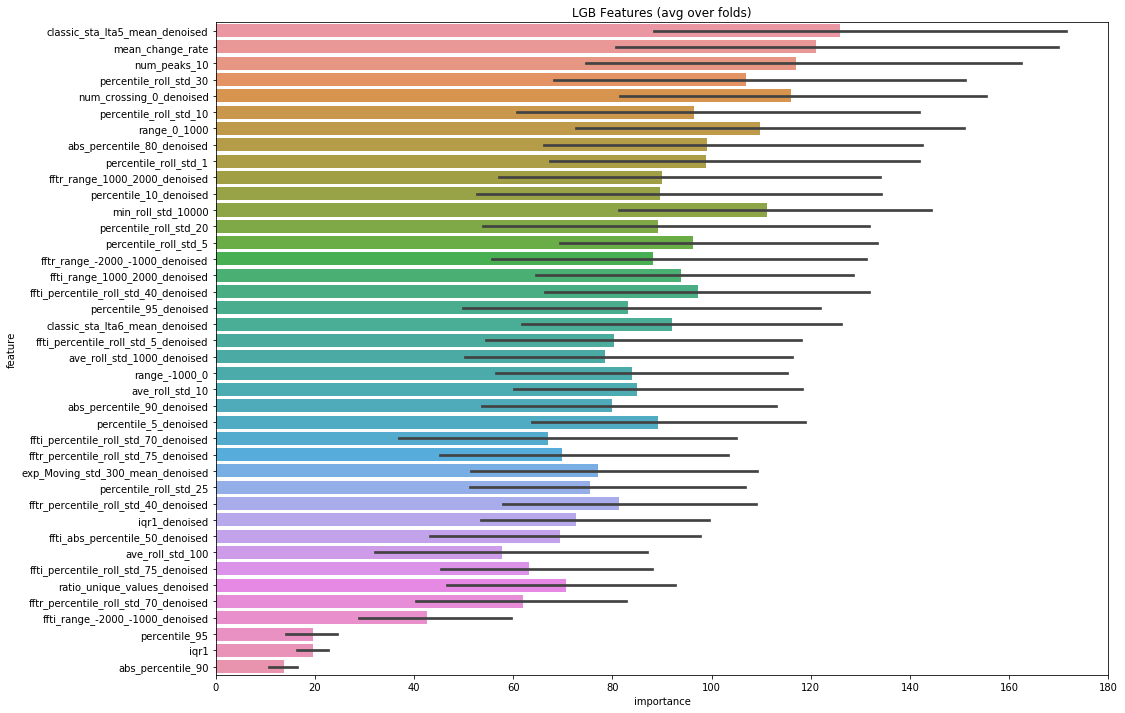

In [18]:
top_num_features = 40
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:top_num_features]
oof_lgb, prediction_lgb, feature_importance = train_model(X[top_features],
                                                          X_test[top_features],
                                                          y,
                                                          params=params,
                                                          folds=folds,
                                                          model_type='lgb',
                                                          plot_feature_importance=True)

In [19]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission_eli5.csv')

## Feature selection

Here I try various approaches to feature selection.

**Important notice**: running feature selection on all features takes a lot of time, so I'll run some of feature selection methods and print the result, which I'll use in the following versions of the kernel, so that I can explore more approaches.

In [20]:
params = {'num_leaves': 32,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 1.0
}

### SelectPercentile

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [21]:
scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
for i in tqdm_notebook(range(5, 105, 5)):
    print(i)
    s1 = SelectPercentile(f_classif, percentile=i)
    X_train1 = s1.fit_transform(X, y.values.astype(int))
    X_test1 = s1.transform(X_test)
    oof, prediction, scores = train_model(X_train1,
                                          X_test1,
                                          y.values.reshape(-1, ),
                                          params=params, folds=folds,
                                          model_type='lgb',
                                          plot_feature_importance=False)
    scores_dict['f_classif'].append(np.mean(scores))
    
    s2 = SelectPercentile(mutual_info_classif, percentile=i)
    X_train1 = s2.fit_transform(X, y.values.astype(int))
    X_test1 = s2.transform(X_test)
    oof, prediction, scores = train_model(X_train1,
                                          X_test1,
                                          y.values.reshape(-1, ),
                                          params=params,
                                          folds=folds,
                                          model_type='lgb',
                                          plot_feature_importance=False)
    scores_dict['mutual_info_classif'].append(np.mean(scores))
    
    scores_dict['n_features'].append(X_train1.shape[1])

5
Fold 0 started at Sun May  5 12:13:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[397]	valid_0's l1: 1.65055	valid_1's l1: 2.10873
Fold 1 started at Sun May  5 12:13:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[578]	valid_0's l1: 1.53578	valid_1's l1: 2.03791
Fold 2 started at Sun May  5 12:13:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[408]	valid_0's l1: 1.63322	valid_1's l1: 2.1629
Fold 3 started at Sun May  5 12:13:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[311]	valid_0's l1: 1.7597	valid_1's l1: 1.94313
Fold 4 started at Sun May  5 12:14:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[295]	valid_0's l1: 1.74704	valid_1's l1: 2.10866
CV mean score: 2.0723, std: 0.0758.
Fold 0 st

Early stopping, best iteration is:
[395]	valid_0's l1: 1.56052	valid_1's l1: 2.03611
Fold 2 started at Sun May  5 12:19:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[385]	valid_0's l1: 1.54366	valid_1's l1: 2.15769
Fold 3 started at Sun May  5 12:19:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[410]	valid_0's l1: 1.56939	valid_1's l1: 1.93718
Fold 4 started at Sun May  5 12:19:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	valid_0's l1: 1.71961	valid_1's l1: 2.08795
CV mean score: 2.0632, std: 0.0740.
Fold 0 started at Sun May  5 12:20:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[333]	valid_0's l1: 1.64503	valid_1's l1: 2.12626
Fold 1 started at Sun May  5 12:20:43 2019
Training until validation scores don't improve for 200 rounds.
Early sto

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	valid_0's l1: 1.74538	valid_1's l1: 1.93121
Fold 4 started at Sun May  5 12:26:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[345]	valid_0's l1: 1.57042	valid_1's l1: 2.07611
CV mean score: 2.0638, std: 0.0805.
Fold 0 started at Sun May  5 12:27:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[347]	valid_0's l1: 1.54216	valid_1's l1: 2.10813
Fold 1 started at Sun May  5 12:27:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[588]	valid_0's l1: 1.30286	valid_1's l1: 2.02374
Fold 2 started at Sun May  5 12:27:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[329]	valid_0's l1: 1.55901	valid_1's l1: 2.16203
Fold 3 started at Sun May  5 12:27:57 2019
Training 

Fold 0 started at Sun May  5 12:36:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[446]	valid_0's l1: 1.38434	valid_1's l1: 2.1059
Fold 1 started at Sun May  5 12:36:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	valid_0's l1: 1.30411	valid_1's l1: 2.01273
Fold 2 started at Sun May  5 12:37:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[260]	valid_0's l1: 1.60974	valid_1's l1: 2.15615
Fold 3 started at Sun May  5 12:37:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	valid_0's l1: 1.69677	valid_1's l1: 1.94426
Fold 4 started at Sun May  5 12:37:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[322]	valid_0's l1: 1.53967	valid_1's l1: 2.08118
CV mean score: 2.0599, std: 0.0742.
70
Fold 0 

Early stopping, best iteration is:
[589]	valid_0's l1: 1.19656	valid_1's l1: 2.00833
Fold 2 started at Sun May  5 12:48:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[323]	valid_0's l1: 1.48978	valid_1's l1: 2.14774
Fold 3 started at Sun May  5 12:48:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	valid_0's l1: 1.61537	valid_1's l1: 1.93391
Fold 4 started at Sun May  5 12:48:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[342]	valid_0's l1: 1.47478	valid_1's l1: 2.08462
CV mean score: 2.0551, std: 0.0756.
90
Fold 0 started at Sun May  5 12:48:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[445]	valid_0's l1: 1.33678	valid_1's l1: 2.0931
Fold 1 started at Sun May  5 12:49:03 2019
Training until validation scores don't improve for 200 rounds.
Early s

In [ ]:
scores_dict = {'f_classif': [2.0746468465171377, 2.0753843541953687, 2.062191535440333, 2.0654327826583034, 2.0643551320704936, 2.0617560048382675,
                             2.061565197738015, 2.0598878198917494, 2.0654865223333143, 2.0632788555735777, 2.058002635080971, 2.051075689018734,
                             2.0472543961304583, 2.052401474353084, 2.055924154798443, 2.0561794619762352, 2.0549680611994963, 2.057123777802326,
                             2.0591868861136904, 2.0577745274024553],
               'mutual_info_classif': [2.0866763775014006, 2.0745431497064324, 2.0564324832516427, 2.060125564781158, 2.067334544167612, 2.0665943783246448,
                                       2.063891669849029, 2.070194051004794, 2.0667490707700447, 2.0681653852378354, 2.0592743636982345, 2.061260741522344,
                                       2.05680667824411, 2.0565047875243003, 2.058252567141659, 2.0554927194831922, 2.0562776429736873, 2.0618179277444084,
                                       2.06364125584214, 2.0577745274024553],
               'n_features': [98, 196, 294, 392, 490, 588, 685, 783, 881, 979, 1077, 1175, 1273, 1370, 1468, 1566, 1664, 1762, 1860, 1958]}

In [ ]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'],
                           value_vars=['mutual_info_classif', 'f_classif'],
                           var_name='metric',
                           value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectPercentile vs CV'
).interactive())

### SelectKBest

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [ ]:
scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
for i in tqdm_notebook(np.arange(10, 1958, 100)):
    print(i)
    s1 = SelectKBest(f_classif, k=i)
    X_train1 = s1.fit_transform(X, y.values.astype(int))
    X_test1 = s1.transform(X_test)
    oof, prediction, scores = train_model(X_train1,
                                          X_test1,
                                          y.values.reshape(-1, ),
                                          params=params,
                                          folds=folds,
                                          model_type='lgb',
                                          plot_feature_importance=False)
    scores_dict['f_classif'].append(np.mean(scores))
    
    s2 = SelectKBest(mutual_info_classif, k=i)
    X_train1 = s2.fit_transform(X, y.values.astype(int))
    X_test1 = s2.transform(X_test)
    oof, prediction, scores = train_model(X_train1,
                                          X_test1,
                                          y.values.reshape(-1, ),
                                          params=params,
                                          folds=folds,
                                          model_type='lgb',
                                          plot_feature_importance=False)
    scores_dict['mutual_info_classif'].append(np.mean(scores))
    
    scores_dict['n_features'].append(X_train1.shape[1])

In [ ]:
scores_dict = {'f_classif': [2.1495892622081354, 2.0778182269587147, 2.0716153738740006, 2.06152950679902, 2.0645162758752553, 2.0627705797004032, 2.0610992303725157,
                             2.057762113735462, 2.0618360883613627, 2.0603197111525984, 2.06081274633874, 2.0580767195278056, 2.0527646572747127, 2.0498353445032533,
                             2.052442594925, 2.0564456881902133, 2.0582284644115365, 2.0558612960548635, 2.0580900016350094, 2.058218782401599],
               'mutual_info_classif': [2.1235703196243687, 2.084958198672301, 2.0596822478390955, 2.053305869981444, 2.063468853227225, 2.0674399950434323, 2.0658618511287874,
                                       2.063003703200445, 2.0653174905858664, 2.0644340327023656, 2.0748993062333523, 2.0587602096358113, 2.0601495560836076, 2.0559629138548603,
                                       2.0553852701221134, 2.058022171415446, 2.060755947658241, 2.057916705462307, 2.056245795262636, 2.0580691870837056],
               'n_features': [10, 110, 210, 310, 410, 510, 610, 710, 810, 910, 1010, 1110, 1210, 1310, 1410, 1510, 1610, 1710, 1810, 1910]}

In [ ]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'],
                           value_vars=['mutual_info_classif', 'f_classif'],
                           var_name='metric',
                           value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectKBest vs CV'
).interactive())

### Dropping highly correlated features

Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

Fold 0 started at Sat May  4 01:27:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[754]	training's l1: 1.26425	valid_1's l1: 2.08858
Fold 1 started at Sat May  4 01:27:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1094]	training's l1: 1.05046	valid_1's l1: 1.98942
Fold 2 started at Sat May  4 01:27:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[510]	training's l1: 1.45754	valid_1's l1: 2.15295
Fold 3 started at Sat May  4 01:27:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[491]	training's l1: 1.50815	valid_1's l1: 1.94263
Fold 4 started at Sat May  4 01:27:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[553]	training's l1: 1.42805	valid_1's l1: 2.07242
CV mean score: 2.0492, std: 0.0745.


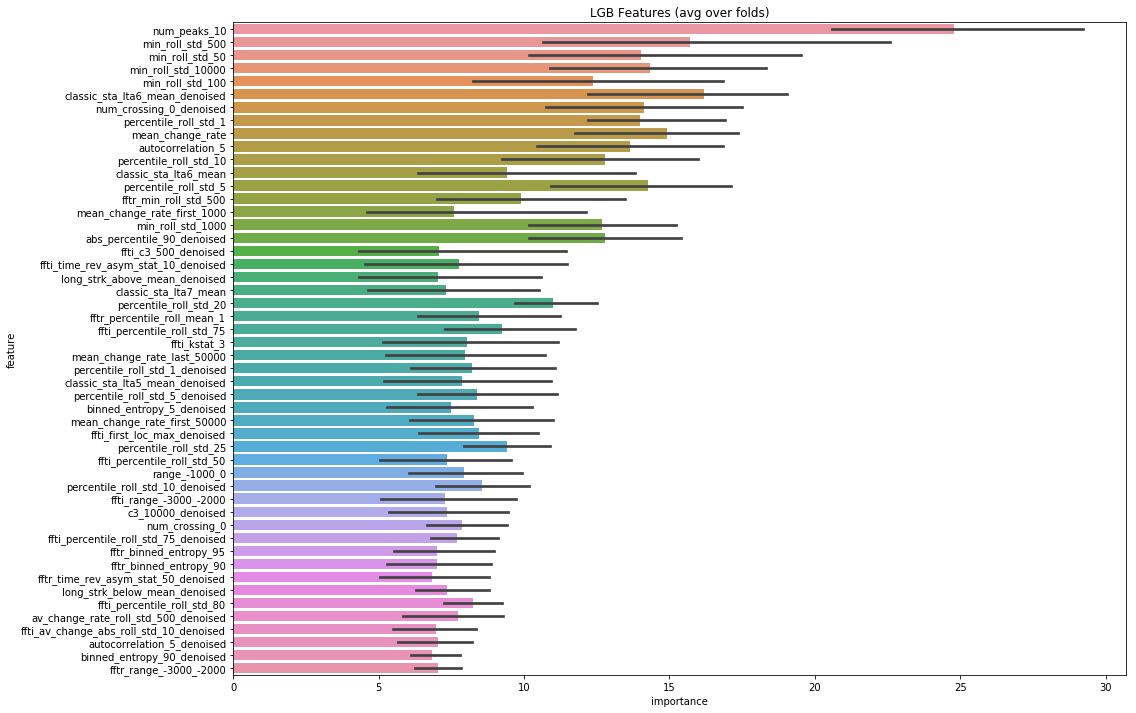

In [12]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X = X.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)
oof_lgb, prediction_lgb, feature_importance = train_model(X,
                                                          X_test,
                                                          y,
                                                          params=params,
                                                          folds=folds,
                                                          model_type='lgb',
                                                          plot_feature_importance=True)

In [ ]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission_no_corr.csv')

### RFE (Feature ranking with recursive feature elimination)

**Important notice**:  I run the cell below in `version 18` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [ ]:
# scores_dict = {'rfe_score': [], 'n_features': []}
# for i in np.arange(10, 1958, 100)[:3]:
#     print(i)
#     s1 = RFE(model, i, step=100)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['rfe_score'].append(np.mean(scores))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [ ]:
scores_dict = {'rfe_score': [2.103586938061856, 2.052535910798748, 2.053228199447811],
               'n_features': [10, 110, 210]
}

In [ ]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['rfe_score'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectKBest vs CV'
).interactive())

## Model comparison

In this section I'll try variuos sklearn models and compair their score. Running GridSearchCV each time is too long, so I'll run it once for each model and use optimal parameters.

In [20]:
rfr = RandomForestRegressor(n_jobs=-1)
#parameter_grid = {'n_estimators': [20, 50, 70, 90],
#                  'max_depth': [4, 8, 16]
#                 }

#grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
#grid_search.fit(X, y)
#print('Best score: {}'.format(grid_search.best_score_))
#print('Best parameters: {}'.format(grid_search.best_params_))
#rfr = RandomForestRegressor(**grid_search.best_params_)
rfr = RandomForestRegressor(n_estimators=90, max_depth=8, n_jobs=-1)
oof_rfr, prediction_rfr, scores_rfr = train_model(X,
                                                  X_test,
                                                  y,
                                                  params=params,
                                                  folds=folds,
                                                  model_type='sklearn',
                                                  model=rfr)

Fold 0 started at Sat May  4 01:30:23 2019
Fold 0. MAE: 2.1371.

Fold 1 started at Sat May  4 01:30:27 2019
Fold 1. MAE: 2.0973.

Fold 2 started at Sat May  4 01:30:32 2019
Fold 2. MAE: 2.1950.

Fold 3 started at Sat May  4 01:30:36 2019
Fold 3. MAE: 1.9981.

Fold 4 started at Sat May  4 01:30:40 2019
Fold 4. MAE: 2.0905.

CV mean score: 2.1036, std: 0.0645.


In [21]:
ridge = linear_model.Ridge(normalize=True)

parameter_grid = {'alpha': [0.1, 0.5, 1.0, 2, 5, 10.0]}

grid_search = GridSearchCV(ridge, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
ridge = linear_model.Ridge(**grid_search.best_params_, normalize=True)
oof_ridge, prediction_ridge, scores_ridge = train_model(X,
                                                        X_test,
                                                        y,
                                                        params=params,
                                                        folds=folds,
                                                        model_type='sklearn',
                                                        model=ridge)

Best score: -2.1480001025822655
Best parameters: {'alpha': 1.0}
Fold 0 started at Sat May  4 01:31:30 2019
Fold 0. MAE: 2.1765.

Fold 1 started at Sat May  4 01:31:30 2019
Fold 1. MAE: 2.1246.

Fold 2 started at Sat May  4 01:31:31 2019
Fold 2. MAE: 2.2160.

Fold 3 started at Sat May  4 01:31:31 2019
Fold 3. MAE: 2.0088.

Fold 4 started at Sat May  4 01:31:32 2019
Fold 4. MAE: 2.2141.

CV mean score: 2.1480, std: 0.0771.


In [22]:
knn = neighbors.KNeighborsRegressor()

parameter_grid = {'n_neighbors': [50, 100, 200, 300, 400]}

grid_search = GridSearchCV(knn, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
knn = neighbors.KNeighborsRegressor(**grid_search.best_params_)
oof_knn, prediction_knn, scores_knn = train_model(X,
                                                  X_test,
                                                  y,
                                                  params=params,
                                                  folds=folds,
                                                  model_type='sklearn',
                                                  model=knn)

Best score: -2.3837244071751296
Best parameters: {'n_neighbors': 200}
Fold 0 started at Sat May  4 01:31:42 2019
Fold 0. MAE: 2.4469.

Fold 1 started at Sat May  4 01:31:44 2019
Fold 1. MAE: 2.3487.

Fold 2 started at Sat May  4 01:31:46 2019
Fold 2. MAE: 2.4617.

Fold 3 started at Sat May  4 01:31:48 2019
Fold 3. MAE: 2.2801.

Fold 4 started at Sat May  4 01:31:50 2019
Fold 4. MAE: 2.3813.

CV mean score: 2.3837, std: 0.0664.


In [26]:
#etr = ExtraTreesRegressor(n_jobs=-1)

#parameter_grid = {'n_estimators': [500, 1000],
#                  'max_depth': [5, 10, 20]
#                }

#grid_search = GridSearchCV(rfr, param_grid=parameter_grid,
#                           cv=folds,
#                           scoring='neg_mean_absolute_error',
#                           verbose=10,
#                           n_jobs=-1)
#grid_search.fit(X, y)
#print('Best score: {}'.format(grid_search.best_score_))
#print('Best parameters: {}'.format(grid_search.best_params_))
#etr = ExtraTreesRegressor(**grid_search.best_params_, n_jobs=-1)
etr = ExtraTreesRegressor(n_estimators=1000, max_depth=10, n_jobs=-1)
oof_etr, prediction_etr, scores_etr = train_model(X,
                                                  X_test,
                                                  y,
                                                  params=params,
                                                  folds=folds,
                                                  model_type='sklearn',
                                                  model=etr)

Fold 0 started at Sun May  5 14:36:03 2019
Fold 0. MAE: 2.1525.

Fold 1 started at Sun May  5 14:36:32 2019
Fold 1. MAE: 2.0966.

Fold 2 started at Sun May  5 14:37:01 2019
Fold 2. MAE: 2.1663.

Fold 3 started at Sun May  5 14:37:30 2019
Fold 3. MAE: 2.0046.

Fold 4 started at Sun May  5 14:37:59 2019
Fold 4. MAE: 2.0900.

CV mean score: 2.1020, std: 0.0572.


In [22]:
adr = AdaBoostRegressor()

parameter_grid = {'n_estimators': [2, 4, 8, 16, 32],
                 }

grid_search = GridSearchCV(adr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
adr = AdaBoostRegressor(**grid_search.best_params_)
oof_dar, prediction_adr, scores_adr = train_model(X,
                                                  X_test,
                                                  y,
                                                  params=params,
                                                  folds=folds, 
                                                  model_type='sklearn',
                                                  model=adr)

Best score: -2.185676823367075
Best parameters: {'n_estimators': 4}
Fold 0 started at Sun May  5 14:29:04 2019
Fold 0. MAE: 2.2512.

Fold 1 started at Sun May  5 14:29:10 2019
Fold 1. MAE: 2.1656.

Fold 2 started at Sun May  5 14:29:15 2019
Fold 2. MAE: 2.2622.

Fold 3 started at Sun May  5 14:29:21 2019
Fold 3. MAE: 2.0116.

Fold 4 started at Sun May  5 14:29:27 2019
Fold 4. MAE: 2.1905.

CV mean score: 2.1762, std: 0.0899.


In [16]:
params_gpi = {
    'activation':'atan'
}
oof_gpi, prediction_gpi, scores_gpi = train_model(X_train_scaled,
                                                  X_test_scaled,
                                                  y,
                                                  params=params_gpi,
                                                  folds=folds,
                                                  model_type='gpi_new')

Fold 0 started at Sat May  4 01:30:02 2019
Fold 1 started at Sat May  4 01:30:02 2019
Fold 2 started at Sat May  4 01:30:03 2019
Fold 3 started at Sat May  4 01:30:04 2019
Fold 4 started at Sat May  4 01:30:04 2019
CV mean score: 1.8859, std: 0.0757.


In [17]:
params_gpii = {
    'activation':'atan'
}
oof_gpii, prediction_gpii, scores_gpii = train_model(X_train_scaled,
                                                     X_test_scaled,
                                                     y,
                                                     params=params_gpii,
                                                     folds=folds,
                                                     model_type='gpii_new')

Fold 0 started at Sat May  4 01:30:05 2019
Fold 1 started at Sat May  4 01:30:06 2019
Fold 2 started at Sat May  4 01:30:06 2019
Fold 3 started at Sat May  4 01:30:07 2019
Fold 4 started at Sat May  4 01:30:08 2019
CV mean score: 1.8942, std: 0.0751.


In [25]:
params_gpiii = {
    'activation':'atan'
}
oof_gpiii, prediction_gpiii, scores_gpiii = train_model(X_train_scaled,
                                                        X_test_scaled,
                                                        y,
                                                        params=params_gpiii,
                                                        folds=folds,
                                                        model_type='gpiii_new')
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_gpiii
submission.to_csv('../output/submission_gpiii_new.csv')

Fold 0 started at Sat May  4 01:33:20 2019
Fold 1 started at Sat May  4 01:33:20 2019
Fold 2 started at Sat May  4 01:33:21 2019
Fold 3 started at Sat May  4 01:33:21 2019
Fold 4 started at Sat May  4 01:33:22 2019
CV mean score: 1.8803, std: 0.0758.


In [27]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame()
scores_df['RandomForestRegressor'] = scores_adr
scores_df['ExtraTreesRegressor'] = scores_etr
scores_df['AdaBoostRegressor'] = scores_adr
scores_df['KNN'] = scores_knn
scores_df['Ridge'] = scores_ridge
scores_df['GPI'] = scores_gpi
scores_df['GPII'] = scores_gpii
scores_df['GPIII'] = scores_gpii

ax = sns.boxplot(data=scores_df);
ax.set(yscale="log")

plt.xticks(rotation=45);

NameError: name 'scores_knn' is not defined

<Figure size 864x576 with 0 Axes>